In [1]:
!git clone https://github.com/MikeOfZen/Yet-Another-Openpose-Implementation.git

Cloning into 'Yet-Another-Openpose-Implementation'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 875 (delta 20), reused 17 (delta 8), pack-reused 838
Receiving objects: 100% (875/875), 189.09 MiB | 37.77 MiB/s, done.
Resolving deltas: 100% (521/521), done.
Checking out files: 100% (86/86), done.


In [1]:
cd /content/Yet-Another-Openpose-Implementation

/content/Yet-Another-Openpose-Implementation


In [ ]:
pip install -r requirements.txt

In [2]:
import cv2
import visualizations as vis
from applications.model_wrapper import ModelWrapper
import configs.draw_config as draw_config

/content/Yet-Another-Openpose-Implementation/post_processing/post.py:110: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @numba.jitclass(spec)


In [3]:
model_path = "/content/Yet-Another-Openpose-Implementation/trained_models/model11_test-15Sun1219-2101"

In [8]:
import tensorflow as tf
import post_processing.post as post
import configs.post_config as post_config
import configs.keypoints_config as kpts_config
import configs.default_config as def_config

post.Skeletonizer.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF, post_config)
post.Skeleton.config(kpts_config.KEYPOINTS_DEF, kpts_config.JOINTS_DEF)


class ModelWrapperCust:
    def __init__(self, model_path):
        self.model = tf.keras.models.load_model(model_path)

    def process_image(self, img):
        input_img = tf.image.resize(img, (def_config.IMAGE_HEIGHT, def_config.IMAGE_WIDTH))
        input_img = tf.image.convert_image_dtype(input_img, dtype=tf.float32)
        input_img /= 255
        input_img = input_img[tf.newaxis, ...]
        pafs, kpts = self.model.predict(input_img)
        pafs = pafs[0]
        kpts = kpts[0]
        skeletonizer = post.Skeletonizer(kpts, pafs)
        skeletons = skeletonizer.create_skeletons()
        return skeletons, kpts, pafs


In [9]:
model_wrapper = ModelWrapperCust(model_path)

In [10]:
imaga = cv2.imread('/content/Pic1.jpg')
imaga = cv2.cvtColor(imaga, cv2.COLOR_BGR2RGB)

In [11]:
import numpy as np
skeletons, heat_maps, pafs = model_wrapper.process_image(imaga)

/content/Yet-Another-Openpose-Implementation/post_processing/post.py:93: NumbaTypeSafetyWarning: unsafe cast from int64 to uint16. Precision may be lost.
  segmented_islands, island_hierarchy = mark_islands(truth_islands)  # segment and label the discontinuous regions, returns a island hierarchy dict.
/content/Yet-Another-Openpose-Implementation/post_processing/post.py:97: NumbaTypeSafetyWarning: unsafe cast from int64 to float32. Precision may be lost.
  peaks, island_max = islands_max(heatmap, segmented_islands, sorted_island_hierarchy)  # get the maximum peak location (and value) for each island


In [12]:
def sort_island_hierarchy(island_hierarchy):
    """converts the hierarchical island dict to a map to the top level island"""
    compact = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.uint16)
    for child, parent in island_hierarchy.items():
        last_parent = child
        while parent != last_parent:
            last_parent = parent
            parent = island_hierarchy[parent]
        compact[child] = last_parent
    return compact

In [15]:
import numba
@numba.njit
def mark_islands(truth_islands) -> (np.ndarray, dict):
    """This creates an array marking separate truth islands in a truth array
    :param truth_islands:2D array bool array
    :return (islands array-of marked islands,island_hierarchy-islands connections dict)"""
    assert len(truth_islands.shape) == 2, "Must be 2D array"
    dim0 = truth_islands.shape[0]
    dim1 = truth_islands.shape[1]
    shape = (dim0 + 1, dim1 + 1)
    islands = np.zeros(shape, dtype=np.uint16)
    island_num = 1
    island_hierarchy = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.uint16)

    for y in range(dim0):
        for x in range(dim1):
            if truth_islands[y, x]:
                iy = y + 1  # to handle array edge case, islands idxs are shifter by one
                ix = x + 1
                above = islands[iy - 1, ix]
                left = islands[iy, ix - 1]
                if not above and not left:
                    islands[iy, ix] = island_num
                    island_hierarchy[island_num] = island_num  # stays None if islands is isolated, or gets changed to master islands later
                    island_num += 1
                elif above and not left:
                    islands[iy, ix] = above
                elif not above and left:
                    islands[iy, ix] = left
                elif above and left:
                    # make above child of left
                    islands[iy, ix] = above
                    if above != left:
                        island_hierarchy[left] = above
    return islands[1:, 1:], island_hierarchy

In [16]:
@numba.njit
def islands_max(heatmap, islands, island_hierarchy):
    """This returns the maximum value from values for each island from islands"""
    dim0 = islands.shape[0]
    dim1 = islands.shape[1]

    # islands_max=np.zeros(LIMIT_NUM_ISLANDS, dtype=np.float32)-1
    islands_max_dict = numba.typed.Dict.empty(key_type=numba.types.uint16, value_type=numba.types.float32)
    for island_num in set(island_hierarchy.values()):
        islands_max_dict[island_num] = 0  # init here, because that's the only way

    peaks = {}
    for y in range(dim0):
        for x in range(dim1):
            if islands[y, x]:
                island_num = islands[y, x]
                top_island_num = island_hierarchy[island_num]
                if heatmap[y, x] > islands_max_dict[top_island_num]:  #
                    islands_max_dict[top_island_num] = heatmap[y, x]
                    peaks[top_island_num] = (y, x)

    # translate to list view and remove island numbers
    peaks_l = []
    islands_max_l = []
    for k in peaks:
        peaks_l.append(peaks[k])
        islands_max_l.append(islands_max_dict[k])

    return peaks_l, islands_max_l

In [79]:
def find_peaks(heatmap, threshold):
    """This takes a 2D heatmap, and returns all peaks on discontinuous regions (islands) for which the heatmap is above the threshold"""
    truth_islands = heatmap > threshold  # get which parts are above the threshold
    segmented_islands, island_hierarchy = mark_islands(truth_islands)  # segment and label the discontinuous regions, returns a island hierarchy dict.
    if not len(island_hierarchy):  # in case nothing found
        return None
    sorted_island_hierarchy = sort_island_hierarchy(island_hierarchy)  # flatten the island hierarchy to point to the top island label
    peaks, island_max = islands_max(heatmap, segmented_islands, sorted_island_hierarchy)  # get the maximum peak location (and value) for each island
    return peaks[0], island_max[0]

In [80]:
import collections
KEYPOINTS_DEF={
 'nose'         :{"idx":0   ,"name":'nose'         ,"side":"C"   ,"ds_idxs":0    ,"mirror_name":None       },
 'sternum'      :{"idx":1   ,"name":'sternum'      ,"side":"C"   ,"ds_idxs":(5,6),"mirror_name":None       },
 'Rshoulder'    :{"idx":2   ,"name":'Rshoulder'    ,"side":"R"   ,"ds_idxs":6    ,"mirror_name":'Lshoulder'},
 'Relbow'       :{"idx":3   ,"name":'Relbow'       ,"side":"R"   ,"ds_idxs":8    ,"mirror_name":'Lelbow'   },
 'Rwrist'       :{"idx":4   ,"name":'Rwrist'       ,"side":"R"   ,"ds_idxs":10   ,"mirror_name":'Lwrist'   },
 'Rhip'         :{"idx":5   ,"name":'Rhip'         ,"side":"R"   ,"ds_idxs":12   ,"mirror_name":'Lhip'     },
 'Rknee'        :{"idx":6   ,"name":'Rknee'        ,"side":"R"   ,"ds_idxs":14   ,"mirror_name":'Lknee'    },
 'Rankle'       :{"idx":7   ,"name":'Rankle'       ,"side":"R"   ,"ds_idxs":16   ,"mirror_name":'Lankle'   },
 'Reye'         :{"idx":8   ,"name":'Reye'         ,"side":"R"   ,"ds_idxs":2    ,"mirror_name":'Leye'     },
 'Rear'         :{"idx":9   ,"name":'Rear'         ,"side":"R"   ,"ds_idxs":4    ,"mirror_name":'Lear'     },
 'Lshoulder'    :{"idx":10  ,"name":'Lshoulder'    ,"side":"L"   ,"ds_idxs":5    ,"mirror_name":'Rshoulder'},
 'Lelbow'       :{"idx":11  ,"name":'Lelbow'       ,"side":"L"   ,"ds_idxs":7    ,"mirror_name":'Relbow'   },
 'Lwrist'       :{"idx":12  ,"name":'Lwrist'       ,"side":"L"   ,"ds_idxs":9    ,"mirror_name":'Rwrist'   },
 'Lhip'         :{"idx":13  ,"name":'Lhip'         ,"side":"L"   ,"ds_idxs":11   ,"mirror_name":'Rhip'     },
 'Lknee'        :{"idx":14  ,"name":'Lknee'        ,"side":"L"   ,"ds_idxs":13   ,"mirror_name":'Rknee'    },
 'Lankle'       :{"idx":15  ,"name":'Lankle'       ,"side":"L"   ,"ds_idxs":15   ,"mirror_name":'Rankle'   },
 'Leye'         :{"idx":16  ,"name":'Leye'         ,"side":"L"   ,"ds_idxs":1    ,"mirror_name":'Reye'     },
 'Lear'         :{"idx":17  ,"name":'Lear'         ,"side":"L"   ,"ds_idxs":3    ,"mirror_name":'Rear'     }
        }
KEYPOINTS_DEF=collections.OrderedDict(sorted(KEYPOINTS_DEF.items(), key=lambda t: t[1]["idx"]))

In [81]:
    def _localize_potential_kpts(KEYPOINTS_DEF, kpts):
        """This converts the trained model output keypoints heatmaps tensor to coordinates of potential keypoint
        coordinates. find_peaks thresholds the input, segmenting the input into islands of certainty
        and for each island finds the max coords.
        for each keypoint type (from KEYPOINT_DEF) it stores all hits
        :returns a dict of kpts vs their locations"""
        confidence_scores = {}
        potential_kpts = {}
        for kpt_name, kpt in KEYPOINTS_DEF.items():
            kpt_idx = kpt["idx"]
            kpt_heatmap = kpts[..., kpt_idx]
            peaks, score = find_peaks(kpt_heatmap, 0.5)
            potential_kpts[kpt_name] = peaks
            confidence_scores[kpt_name] = score
        return potential_kpts, confidence_scores

In [82]:
coordinates, scores = _localize_potential_kpts(KEYPOINTS_DEF, heat_maps)

In [83]:
coordinates

{'nose': (6, 25),
 'sternum': (11, 25),
 'Rshoulder': (11, 20),
 'Relbow': (14, 15),
 'Rwrist': (11, 9),
 'Rhip': (21, 22),
 'Rknee': (30, 23),
 'Rankle': (36, 22),
 'Reye': (6, 24),
 'Rear': (6, 23),
 'Lshoulder': (11, 30),
 'Lelbow': (17, 32),
 'Lwrist': (22, 31),
 'Lhip': (22, 28),
 'Lknee': (30, 28),
 'Lankle': (37, 22),
 'Leye': (6, 26),
 'Lear': (6, 27)}

In [113]:
pairs = ((1, 2), (1, 10), (2, 3), (3, 4), (10, 11), (11, 12), (2, 5), (5, 6), (6, 7), (10, 13), (13, 14), (14, 15), (5, 13))

In [84]:
scores

{'nose': 0.9372541904449463,
 'sternum': 0.9474572539329529,
 'Rshoulder': 0.943804144859314,
 'Relbow': 0.836216390132904,
 'Rwrist': 0.8074321150779724,
 'Rhip': 0.8931748270988464,
 'Rknee': 0.7896871566772461,
 'Rankle': 0.7399935126304626,
 'Reye': 0.9549451470375061,
 'Rear': 0.9526678323745728,
 'Lshoulder': 0.9352707862854004,
 'Lelbow': 0.9177805185317993,
 'Lwrist': 0.8006762266159058,
 'Lhip': 0.9050248861312866,
 'Lknee': 0.9532408714294434,
 'Lankle': 0.7623472809791565,
 'Leye': 0.9560261368751526,
 'Lear': 0.9586090445518494}

In [61]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [68]:
print(f'The lowest score: {get_key(scores, min(scores.values()))} = {min(scores.values())}')
print(f'Mean confidence score for all points: {np.array(list(scores.values())).mean()}')

The lowest score: Rankle = 0.7399935126304626
Mean confidence score for all points: 0.8884226845370399


In [71]:
LABEL_HEIGHT_RANGE = heat_maps.shape[0] - 1
LABEL_WIDTH_RANGE = heat_maps.shape[1] - 1

In [72]:
def _normalize_coord(coord):
    normalized_y = coord[0] / LABEL_HEIGHT_RANGE
    normalized_x = coord[1] / LABEL_WIDTH_RANGE
    return (normalized_y, normalized_x)

In [74]:
    def _scale_flip_coord(coord):
        y = coord[0]
        x = coord[1]
        scaled_y = int(y * imaga.shape[0])
        scaled_x = int(x * imaga.shape[1])
        return scaled_x, scaled_y

In [87]:
true_kpts = []
for value in coordinates.values():
  true_kpts.append((_scale_flip_coord(_normalize_coord(value))))

In [102]:
true_kpts

[(673, 219),
 (673, 402),
 (539, 402),
 (404, 512),
 (242, 402),
 (593, 768),
 (619, 1098),
 (593, 1317),
 (646, 219),
 (619, 219),
 (808, 402),
 (862, 622),
 (835, 805),
 (754, 805),
 (754, 1098),
 (593, 1354),
 (700, 219),
 (727, 219)]

In [114]:
for pair in pairs:
  p_1 = pair[0]
  p_2 = pair[1]
  cv2.line(imaga, true_kpts[p_1], true_kpts[p_2], [0, 255, 16], 4)

In [115]:
import cv2
# draw points
for p in true_kpts:
  cv2.circle(imaga, p, 6, [0, 0, 255], -1)

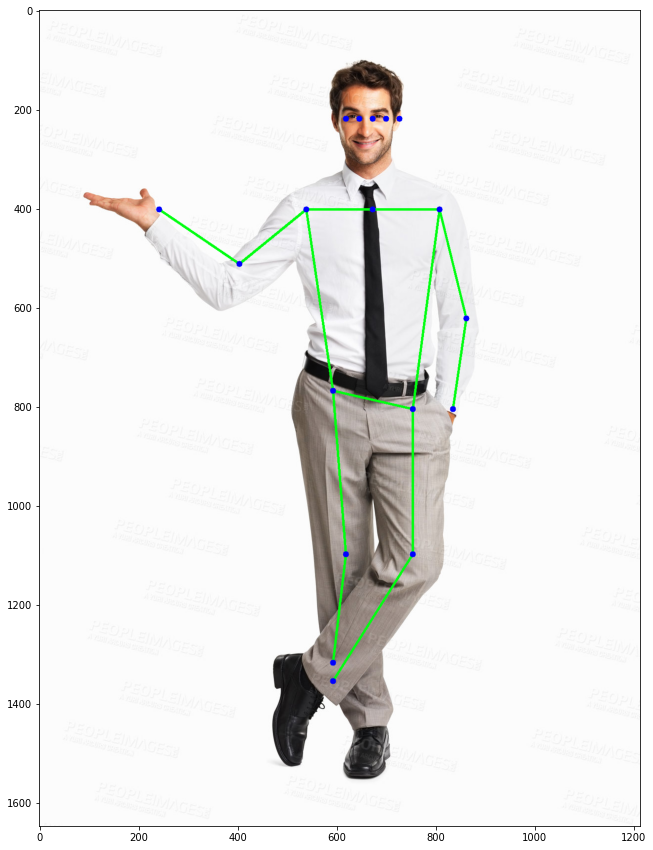

In [116]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
plt.imshow(imaga)